In [ ]:
import torch
import torchvision
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Set device to cuda if available

In [ ]:
# Download the FashionMNIST dataset, which contains tensors with pixels and labels
train_data = datasets.FashionMNIST(
    root="data",
    train = True,
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform= None
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform= None,

)

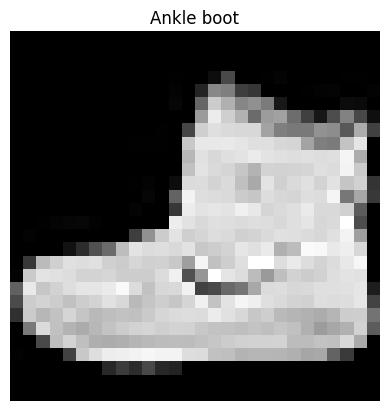

In [ ]:
# Display a single image with its label
image, label = train_data[0]
class_names = train_data.classes
class_to_idx = train_data.class_to_idx

plt.imshow(image.squeeze(), cmap = "gray")
plt.title(class_names[label])
plt.axis(False);

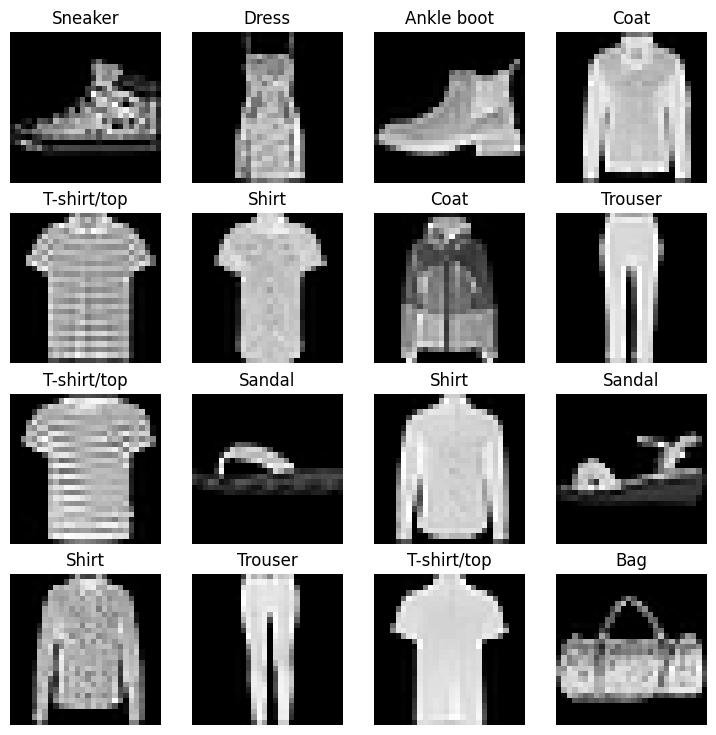

In [ ]:
# Display multiple images
fig = plt.figure(figsize= (9,9))
rows, cols = 4,4
for i in range (1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap = "gray")
  plt.title(class_names[label])
  plt.axis(False);

In [ ]:
from torch.utils.data import DataLoader

# Download the FashionMNIST dataset, which contains tensors with pixels and labels
train_data = datasets.FashionMNIST(
    root="data",
    train = True,
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform= None
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform= None,

)

# A batch is a collection of images. The neural network processes a batch and updates its weights. A higher batch size generally means faster training but potentially lower accuracy.

Batch_size = 32 # means how many pictures are in one batch


# Data needs to be split into training and testing datasets. The neural network is trained on the training data and evaluated on the test data, which it has not seen before.
train_dataloader = DataLoader(dataset = train_data,
                              batch_size= Batch_size,
                              shuffle = True)


test_dataloader = DataLoader(dataset = test_data,
                              batch_size= Batch_size,
                              shuffle = False)

train_dataloader, test_dataloader

train_features_batch, train_labels_batch = next(iter(train_dataloader))

In [ ]:
# Download and import helper functions, there are lots of useful functions here
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions exist")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions exist


In [ ]:
from helper_functions import *

from tqdm.auto import tqdm # Library for better visualization of training

In [ ]:
def training_loop(model,
                  epochs:int,
                  train_dataloader,
                  test_dataloader,
                  device):

  model.train() # Switch model to train mode

  for epoch in tqdm(range(epochs)): # epoch = one pass over the entire dataset
    print(f"Epoch: {epoch}\n-----")

    train_loss = 0
    for batch, (x, y) in enumerate(train_dataloader):
      x = x.to(device)
      y = y.to(device)

      # Pass data to the model to get predictions
      y_pred = model(x)

      loss = loss_fn(y_pred, y) # Calculate the loss function, which measures how well the model performed
      train_loss += loss

      optimizer.zero_grad() # This is crucial for backpropagation

      loss.backward() # This updates the model's weights based on the loss function, optimizer, and learning rate

      optimizer.step() # Take another step in the optimizer

      if batch % 400 == 0:
        print(f"Looked at {batch * len(x)}/{len(train_dataloader.dataset)} samples.")

    train_loss /= len(train_dataloader) # Calculate the loss for the entire batch

    test_loss = 0
    test_acc = 0

    model.eval() # Switch model to evaluation mode

    with torch.inference_mode():
      # Make predictions on the test data
      for batch, (x_test, y_test) in enumerate(test_dataloader):
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        test_pred = model(x_test)

        test_loss += loss_fn(test_pred, y_test)

        test_acc += accuracy_fn(y_test, test_pred.argmax(dim = 1)) # Calculate accuracy

      test_loss /= len(test_dataloader)

      test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4}")



In [ ]:
torch.manual_seed(42)

# Function for easy evaluation of your model
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  loss,acc = 0,0
  model.eval()
  with torch.inference_mode():
    for x, y in data_loader:
      x = x.to(device)
      y = y.to(device)
      y_pred = model(x)

      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y, y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name":model.__class__.__name__,
          "model_loss":loss.item(),
          "model_acc": acc}

In [ ]:
# Model configuration
class FashionMNISTModelV2(nn.Module):

  def __init__(self, input_shapes: int, hidden_units: int, output_shape: int):
    super().__init__()

    # There are 2 convolutional blocks, each containing Convolution, ReLU, and MaxPool layers.
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shapes,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    # Flatten the data into an understandable format
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*7*7,
                  out_features = output_shape)
    )

  # The forward method passes data through every layer and outputs the final results
  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x.squeeze(1))

    return x

In [ ]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shapes = 1, hidden_units = 20, output_shape = len(class_names)).to(device) # Instance of the model

In [ ]:
loss_fn = nn.CrossEntropyLoss() # Set loss function
optimizer = torch.optim.SGD(params= model_2.parameters(),
                            lr = 0.01) # Set optimizer; you can adjust the learning rate (lr)

In [ ]:
training_loop(model_2, 50, train_dataloader, test_dataloader, device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 1.0880 | Test loss: 0.5452 | Test acc: 79.55
Epoch: 1
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4675 | Test loss: 0.4499 | Test acc: 83.7
Epoch: 2
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.3987 | Test loss: 0.4457 | Test acc: 83.12
Epoch: 3
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.3638 | Test loss: 0.3743 | Test acc: 86.68
Epoch: 4
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
L

In [ ]:
# evaluate the model
model_2_results = eval_model(
    model_2,
    test_dataloader,
    loss_fn,
    accuracy_fn
)

model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.25661036372184753,
 'model_acc': 91.05431309904154}

In [ ]:
# This function makes predictions and displays the results
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim = 0).to(device)


      pred_logit = model(sample)

      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [ ]:
import random

# Choose 9 random images
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k = 9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

In [ ]:
# Make predictions on the trained model
pred_probs = make_predictions(model_2, test_samples)
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([0, 4, 7, 3, 3, 2, 9, 6, 2])

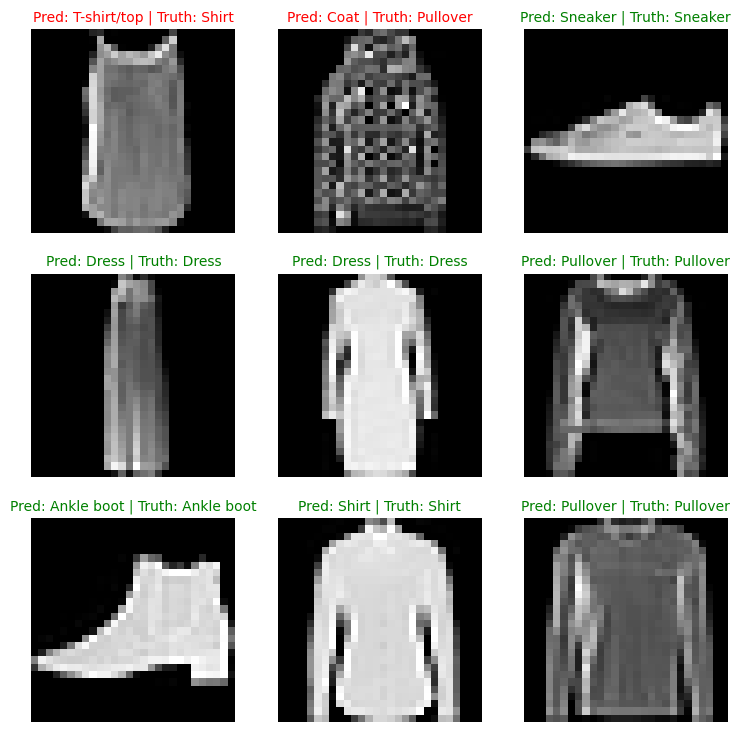

In [ ]:
# Plot predictions
plt.figure(figsize= (9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap = "gray")
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
    plt.title(title_text, fontsize = 10, c="g")

  else:
    plt.title(title_text, fontsize = 10, c="r")
  plt.axis(False);